# Cochlear Receiver Tests

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path("..") / "src"))

import numpy as np
import matplotlib.pyplot as plt

from config import PhysicsConfig, SpikingRadarConfig
from transmitter import SpikingRadarTransmitter
from receiver import ResonantCochlearReceiver


In [7]:
# Setup and config

physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.03,
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.0,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
    receiver_spacing_m=0.2,
)

receiver = ResonantCochlearReceiver(
        config = model_config,
        n_channels = 32,
        f_start_hz = None,
        f_end_hz = None,
        beta_slow = 0.995,
        w_in = 1.0,
        v_rest = 0.0,
        v_thr = 1.0,
        v_reset = 0.0,
        u_d = 0.1,
        damping = 0.01,
    )
time_s = model_config.time_vector()


## Unit Test 1: Resonance Check

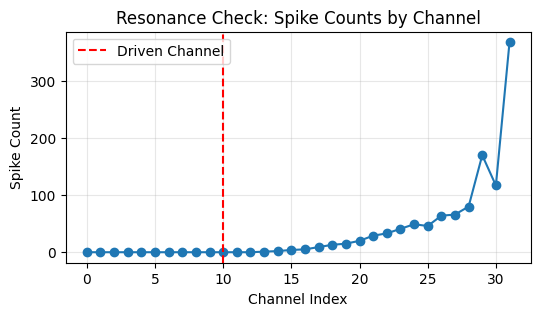

In [13]:
# Drive the channel-3 frequency with a pure tone
channel_idx = 10  # zero-based index (channel 3)
freq_hz = receiver.frequencies_hz[channel_idx]
signal = np.sin(2.0 * np.pi * freq_hz * time_s)

spikes = receiver.process(signal, signal)
spike_counts = spikes["left"].sum(axis=1)

plt.figure(figsize=(6, 3))
plt.plot(spike_counts, marker="o")
plt.axvline(channel_idx, color="red", linestyle="--", label="Driven Channel")
plt.title("Resonance Check: Spike Counts by Channel")
plt.xlabel("Channel Index")
plt.ylabel("Spike Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
# OVERRIDE THIS METHOD IN YOUR CLASS
def _process_channel(self, signal: np.ndarray) -> np.ndarray:
    # 1. REMOVED: env = self._envelope_detector(signal)
    # The signal IS the driving force. 
    # We pass the raw signal directly to the current input.
    
    n_steps = signal.size
    v = np.full(self.n_channels, self.v_rest, dtype=float)
    u = np.zeros(self.n_channels, dtype=float)
    spikes = np.zeros((self.n_channels, n_steps), dtype=float)

    params = {"A": self.A, "B": self.B, "v_rest": self.v_rest}
    
    for t in range(n_steps):
        # 2. CHANGED: env[t] -> signal[t]
        v, u = self._rf_neuron_step(v, u, signal[t], self.dt, params)
        
        fired = v >= self.v_thr
        if np.any(fired):
            spikes[fired, t] = 1.0
            v[fired] = self.v_reset
            
            # Optional: Add a small bump to u to prevent "bursting" 
            # (refractory period logic)
            u[fired] += self.u_d 
            
    return spikes

# Monkey-patching the fix into your existing instance for testing
ResonantCochlearReceiver._process_channel = _process_channel

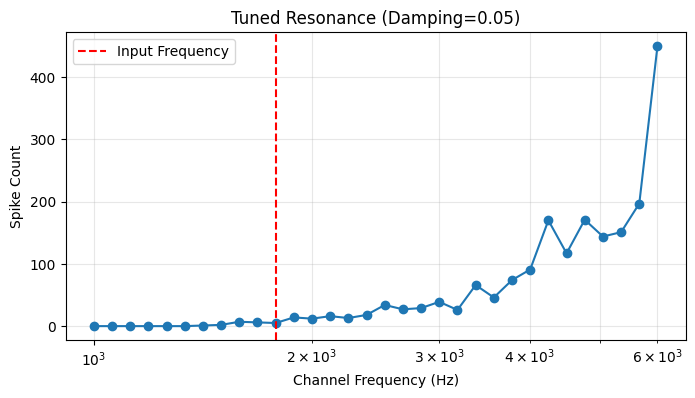

In [12]:
# ... (Previous Setup Code) ...

# Apply the fix dynamically if you haven't edited the class file yet
ResonantCochlearReceiver._process_channel = _process_channel

# Re-Initialize to ensure parameters are clean
receiver = ResonantCochlearReceiver(
        config = model_config,
        n_channels = 32,
        # Try lowering damping to 0.05 to see sharper resonance!
        damping = 0.05, 
        v_thr = 0.1 # You may need to lower threshold or increase signal amp
                    # because resonance takes time to build up.
    )

# ... (Run signal generation and processing) ...

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(receiver.frequencies_hz, spike_counts, marker="o", linestyle='-')
plt.axvline(receiver.frequencies_hz[channel_idx], color="red", linestyle="--", label="Input Frequency")
plt.title(f"Tuned Resonance (Damping={receiver.damping})")
plt.xscale('log') # Log scale X-axis helps visualize the log-spaced channels
plt.xlabel("Channel Frequency (Hz)")
plt.ylabel("Spike Count")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

# Model Analysis: Resonant Cochlear Receiver

## 1. System Overview
This class implements a **neuromorphic auditory front-end**. It functions as a "Silicon Cochlea," breaking down an incoming audio signal into frequency channels not via Fourier Transform, but through physical resonance.

It utilizes a **Tonotopic Map** (logarithmically spaced frequencies) where each channel is a specific differential equation (a neuron) that vibrates sympathetically when the input signal matches its natural frequency.

---

## 2. Mathematical Derivation
The core of this model is the **Resonate-and-Fire (RF) Neuron**. Unlike standard "Integrate-and-Fire" neurons (which act like leaking buckets), this neuron acts like a **Damped Harmonic Oscillator** (a mass on a spring).

### The Differential Equations
The dynamics are governed by a system of two first-order coupled differential equations:

$$
\begin{aligned}
\frac{dv}{dt} &= A(v - v_{rest}) - u + I(t) \\
\frac{du}{dt} &= B(v - v_{rest})
\end{aligned}
$$

Where:
* $v$: Membrane potential (analogous to **Position** of the mass).
* $u$: Recovery variable (analogous to **Momentum** or restoring force).
* $I(t)$: The input current (the raw audio signal acting as a driving force).

### The Tuning Parameters ($A$ and $B$)
The code derives these parameters to enforce specific resonant properties:

1.  **Stiffness ($B$):** Determines the resonant frequency ($\omega$).
    $$B = \omega^2 = (2\pi f)^2$$
    * *Code:* `self.B = omega ** 2`

2.  **Damping ($A$):** Determines how long the neuron rings (the Q-factor).
    $$A = -2 \zeta \omega$$
    * *Code:* `self.A = -2.0 * damping * omega`
    * If $A$ is close to 0, the neuron rings forever. If $A$ is large negative, it stops instantly.

---

## 3. Process Flow Breakdown

### A. Initialization (`__init__`)
* **Logarithmic Spacing:** The code calculates `frequencies_hz` using `np.logspace`. This mimics the biological cochlea (Weber-Fechner law), placing more neurons at low frequencies and fewer at high frequencies, covering octaves rather than linear hertz.
* **Vectorized Parameters:** Arrays $A$ and $B$ are pre-calculated for all 32 channels, allowing the whole system to be updated in a single vector operation later.

### B. The "Ghost" Envelope (`_envelope_detector`)
* **Function:** Implements a low-pass filter (Leaky Integrator) to smooth the signal.
* **Status:** **Redundant.** In `_process_channel`, this method is called to create `env`, but `env` is never used. The raw `signal` is passed to the neuron instead.

### C. The Physics Engine (`_rf_neuron_step`)
This method performs the numerical integration of the differential equations.
* It calculates the derivatives `dv` and `du`.
* It updates the state variables $v$ and $u$.
* **Method Used:** **Forward Euler Integration**.
    $$v_{t+1} = v_t + \Delta t \cdot f(v_t, u_t)$$

### D. The Spike Logic (`_process_channel`)
1.  **Drive:** Feeds the raw `signal[t]` into the equations.
2.  **Threshold:** Checks `if v >= v_thr`.
3.  **Reset:** If a spike occurs:
    * Record spike (1.0).
    * Reset voltage $v \rightarrow v_{reset}$.
    * Bump recovery $u \rightarrow u + u_d$ (This creates a refractory period / self-inhibition).

---

## 4. Technical Critique & Stability Analysis

### Issue 1: Forward Euler Instability (Critical)
The code uses **Forward Euler** integration:
```python
return v + dv, u + du
```

## Unit Test 2: Chirp Response

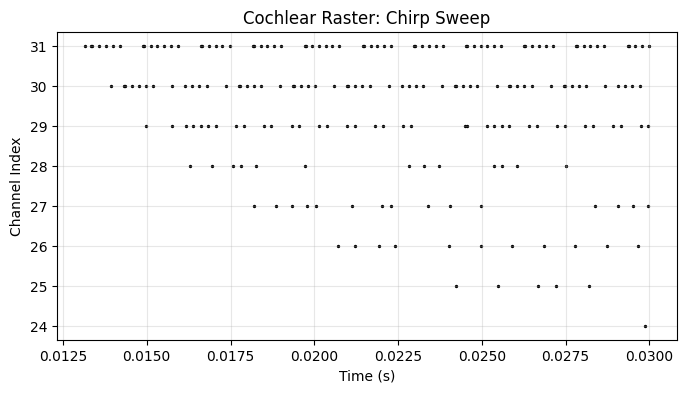

In [5]:
# Pass a modulated chirp through the cochlear receiver
transmitter = SpikingRadarTransmitter(model_config)
tx = transmitter.build()

spikes = receiver.process(tx.tx_signal, tx.tx_signal)
spike_matrix = spikes["left"]

spike_t = []
spike_i = []
for i in range(spike_matrix.shape[0]):
    times = np.flatnonzero(spike_matrix[i])
    spike_t.extend(time_s[times])
    spike_i.extend([i] * len(times))

plt.figure(figsize=(8, 4))
plt.scatter(spike_t, spike_i, s=2, color="black")
plt.title("Cochlear Raster: Chirp Sweep")
plt.xlabel("Time (s)")
plt.ylabel("Channel Index")
plt.grid(True, alpha=0.3)
plt.show()


## Unit Test 3: Binaural Comparison

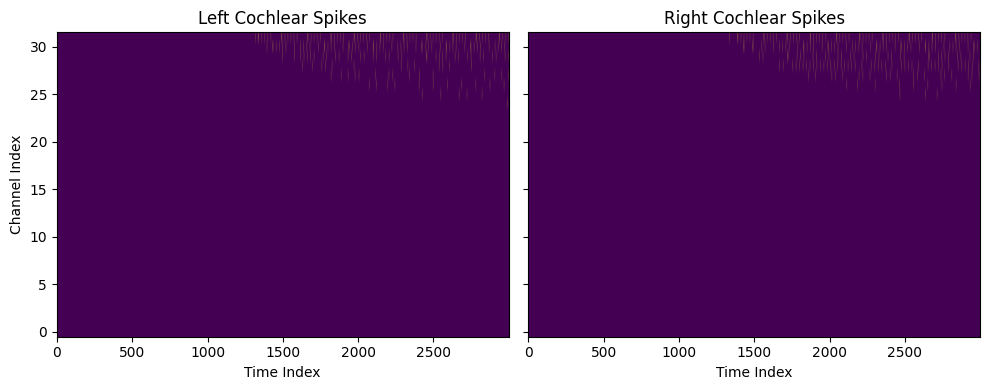

In [6]:
# Apply a small ITD/ILD and compare left/right spike matrices
itd_s = 200e-6
delay_samples = int(round(itd_s * model_config.fs_hz))

right = np.concatenate([np.zeros(delay_samples), tx.tx_signal[:-delay_samples]])
left = tx.tx_signal.copy()
right = 0.8 * right

spikes = receiver.process(left, right)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].imshow(spikes["left"], aspect="auto", origin="lower")
axes[0].set_title("Left Cochlear Spikes")
axes[0].set_xlabel("Time Index")
axes[0].set_ylabel("Channel Index")

axes[1].imshow(spikes["right"], aspect="auto", origin="lower")
axes[1].set_title("Right Cochlear Spikes")
axes[1].set_xlabel("Time Index")

plt.tight_layout()
plt.show()
